# Keras-Structured-Data-Predicting-Adopted-Pets

Welcome to a new Keras project!

In this project, we are demonstrating how to classify structured data (e.g. tabular data in a CSV). We will use Keras to define the model, and preprocessing layers as a bridge to map from columns in a CSV to features used to train the model.

Main steps include:
* Loading a CSV file using [Pandas](https://pandas.pydata.org/).
* Building an input pipeline to batch and shuffle the rows using [tf.data](https://www.tensorflow.org/guide/datasets).
* Mapping from columns in the CSV to features used to train the model using Keras Preprocessing layers.
* Building, training, and evaluating a model using Keras.


## Table of Contents
- [1 - Set up the working directory & Import packages ](#1)
- [2 - Load the dataset using Pandas](#2)
- [3 - Preprocess the dataset](#3)
    - [3.1 - Create target variable ](#3-1)
    - [3.2 - Split the dataframe into train, validation, and test](#3-2)
    - [3.3 - Create an input pipeline to batch and shuffle the rows using tf.data](#3-3)
    - [3.4 - Use Keras preprocessing layers API for feature engineering](#3-4)
    - [3.5 - Create a new input pipeline with a larger batch size](#3-5)
- [4 - Build the model](#4)
    - [4.1 - Create & compile the model](#4-1)
    - [4.2 - Train & evaluate the model](#4-2)
- [5 - Inference on new data](#5)


<a name='1'></a>
## 1 - Set up the working directory & Import packages ##

In [1]:
# Move to the working directory on Google Drive as using Google Colab
import os

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  PROJECT_ROOT ="/content/drive/MyDrive/GitHub/Keras-Structured-Data-Predicting-Adopted-Pets"
  os.chdir(PROJECT_ROOT)
  !pwd
else:
  PROJECT_ROOT ="."

Running on CoLab
/content/drive/MyDrive/GitHub/Keras-Structured-Data-Predicting-Adopted-Pets


In [2]:
!pip install -q sklearn

In [37]:
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('talk')

params = {'legend.fontsize': 12,
          'figure.figsize': (10, 5),
          'axes.labelsize': 12,
          'axes.titlesize':12,
          'xtick.labelsize':12,
          'ytick.labelsize':12}

plt.rcParams.update(params)

<a name='2'></a>
## 2 - Load the dataset using Pandas ##

This is a simplified version of the PetFinder [dataset](https://www.kaggle.com/c/petfinder-adoption-prediction). There are several thousand rows in the CSV. Each row describes a pet, and each column describes an attribute. We will use this information to predict if the pet will be adopted.

Following is a description of this dataset. Notice there are both numeric and categorical columns. There is a free text column but we will not use in this project.

Column | Description| Feature Type | Data Type
------------|--------------------|----------------------|-----------------
Type | Type of animal (Dog, Cat) | Categorical | string
Age |  Age of the pet | Numerical | integer
Breed1 | Primary breed of the pet | Categorical | string
Color1 | Color 1 of pet | Categorical | string
Color2 | Color 2 of pet | Categorical | string
MaturitySize | Size at maturity | Categorical | string
FurLength | Fur length | Categorical | string
Vaccinated | Pet has been vaccinated | Categorical | string
Sterilized | Pet has been sterilized | Categorical | string
Health | Health Condition | Categorical | string
Fee | Adoption Fee | Numerical | integer
Description | Profile write-up for this pet | Text | string
PhotoAmt | Total uploaded photos for this pet | Numerical | integer
AdoptionSpeed | Speed of adoption | Classification | integer

Since this is a relatively small structed data, we will use Pandas to download it from a URL, and load it into a Pandas dataframe.

In [ ]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir=PROJECT_ROOT)
dataframe = pd.read_csv(csv_file)

In [6]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


<a name='3'></a>
## 3 - Preprocess the dataset ##

<a name='3-1'></a>
### 3.1 - Create target variable 
The task in the Kaggle competition is to predict the speed at which a pet will be adopted (e.g., in the first week, the first month, the first three months, and so on). Let's simplify this for our tutorial. Here, you will transform this into a binary classification problem, and simply predict whether the pet was adopted, or not.

After modifying the label column, 0 will indicate the pet was not adopted, and 1 will indicate it was.

In [7]:
# In the original dataset "4" indicates the pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop un-used columns.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,target
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,1


<a name='3-2'></a>
### 3.2 - Split the dataframe into train, validation, and test


In [8]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

7383 train examples
1846 validation examples
2308 test examples


<a name='3-3'></a>
### 3.3 - Create an input pipeline to batch and shuffle the rows using tf.data

In [9]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [10]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor([ 1  3  2  2 24], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([1 1 1 1 0], shape=(5,), dtype=int64)


<a name='3-4'></a>
### 3.4 - Use Keras preprocessing layers API for feature engineering ###

#### Numeric columns
For each of the numeric features, we use a Normalization() layer to make sure the mean of each feature is 0 and its standard deviation is 1.

In [11]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [13]:
# Testing
photo_count_col = train_features['PhotoAmt']
layer = get_normalization_layer('PhotoAmt', train_ds)
print(photo_count_col)
print(layer(photo_count_col))

tf.Tensor([7 5 3 1 1], shape=(5,), dtype=int64)
tf.Tensor([ 1.0761638   0.4429193  -0.19032517 -0.82356966 -0.82356966], shape=(5,), dtype=float32)


#### Categorical columns
For each of the categorical features, we use a [`StringLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/StringLookup) / [`IntegerLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/IntegerLookup) layer to map strings/integers from a vocabulary to integer indices and [`CategoryEncoding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/CategoryEncoding) layer for ene-hot encoding.

In [20]:
def get_category_string_encoding_layer(name, dataset, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  index = preprocessing.StringLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

In [21]:
# Testing 1
type_col = train_features['Type']
layer = get_category_string_encoding_layer('Type', train_ds,max_tokens=5)
print(type_col)
print(layer(type_col))

tf.Tensor([b'Cat' b'Cat' b'Dog' b'Dog' b'Cat'], shape=(5,), dtype=string)
tf.Tensor([0. 1. 1.], shape=(3,), dtype=float32)


In [22]:
def get_category_integer_encoding_layer(name, dataset, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

In [23]:
# Testing 2
type_col = train_features['Age']
category_encoding_layer = get_category_integer_encoding_layer('Age', train_ds, 5)
print(type_col)
print(category_encoding_layer(type_col))

tf.Tensor([ 1  3  2  2 24], shape=(5,), dtype=int64)
tf.Tensor([1. 1. 1. 1. 0.], shape=(5,), dtype=float32)


<a name='3-5'></a>
### 3.5 - Create a new input pipeline with a larger batch size ###

In [24]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [25]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

# Categorical features encoded as integers.
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')
encoding_layer = get_category_integer_encoding_layer('Age', train_ds, max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)


# Categorical features encoded as string.
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_string_encoding_layer(header, train_ds,max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

<a name='4'></a>
## 4 - Build the model ## 

<a name='4-1'></a>
### 4.1 - Create & compile the model

We are using [Keras-functional API](https://www.tensorflow.org/guide/keras/functional) to build the model. The Keras functional API is a way to create models that are more flexible than the [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) API.

In [27]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

Let's visualize our connectivity graph

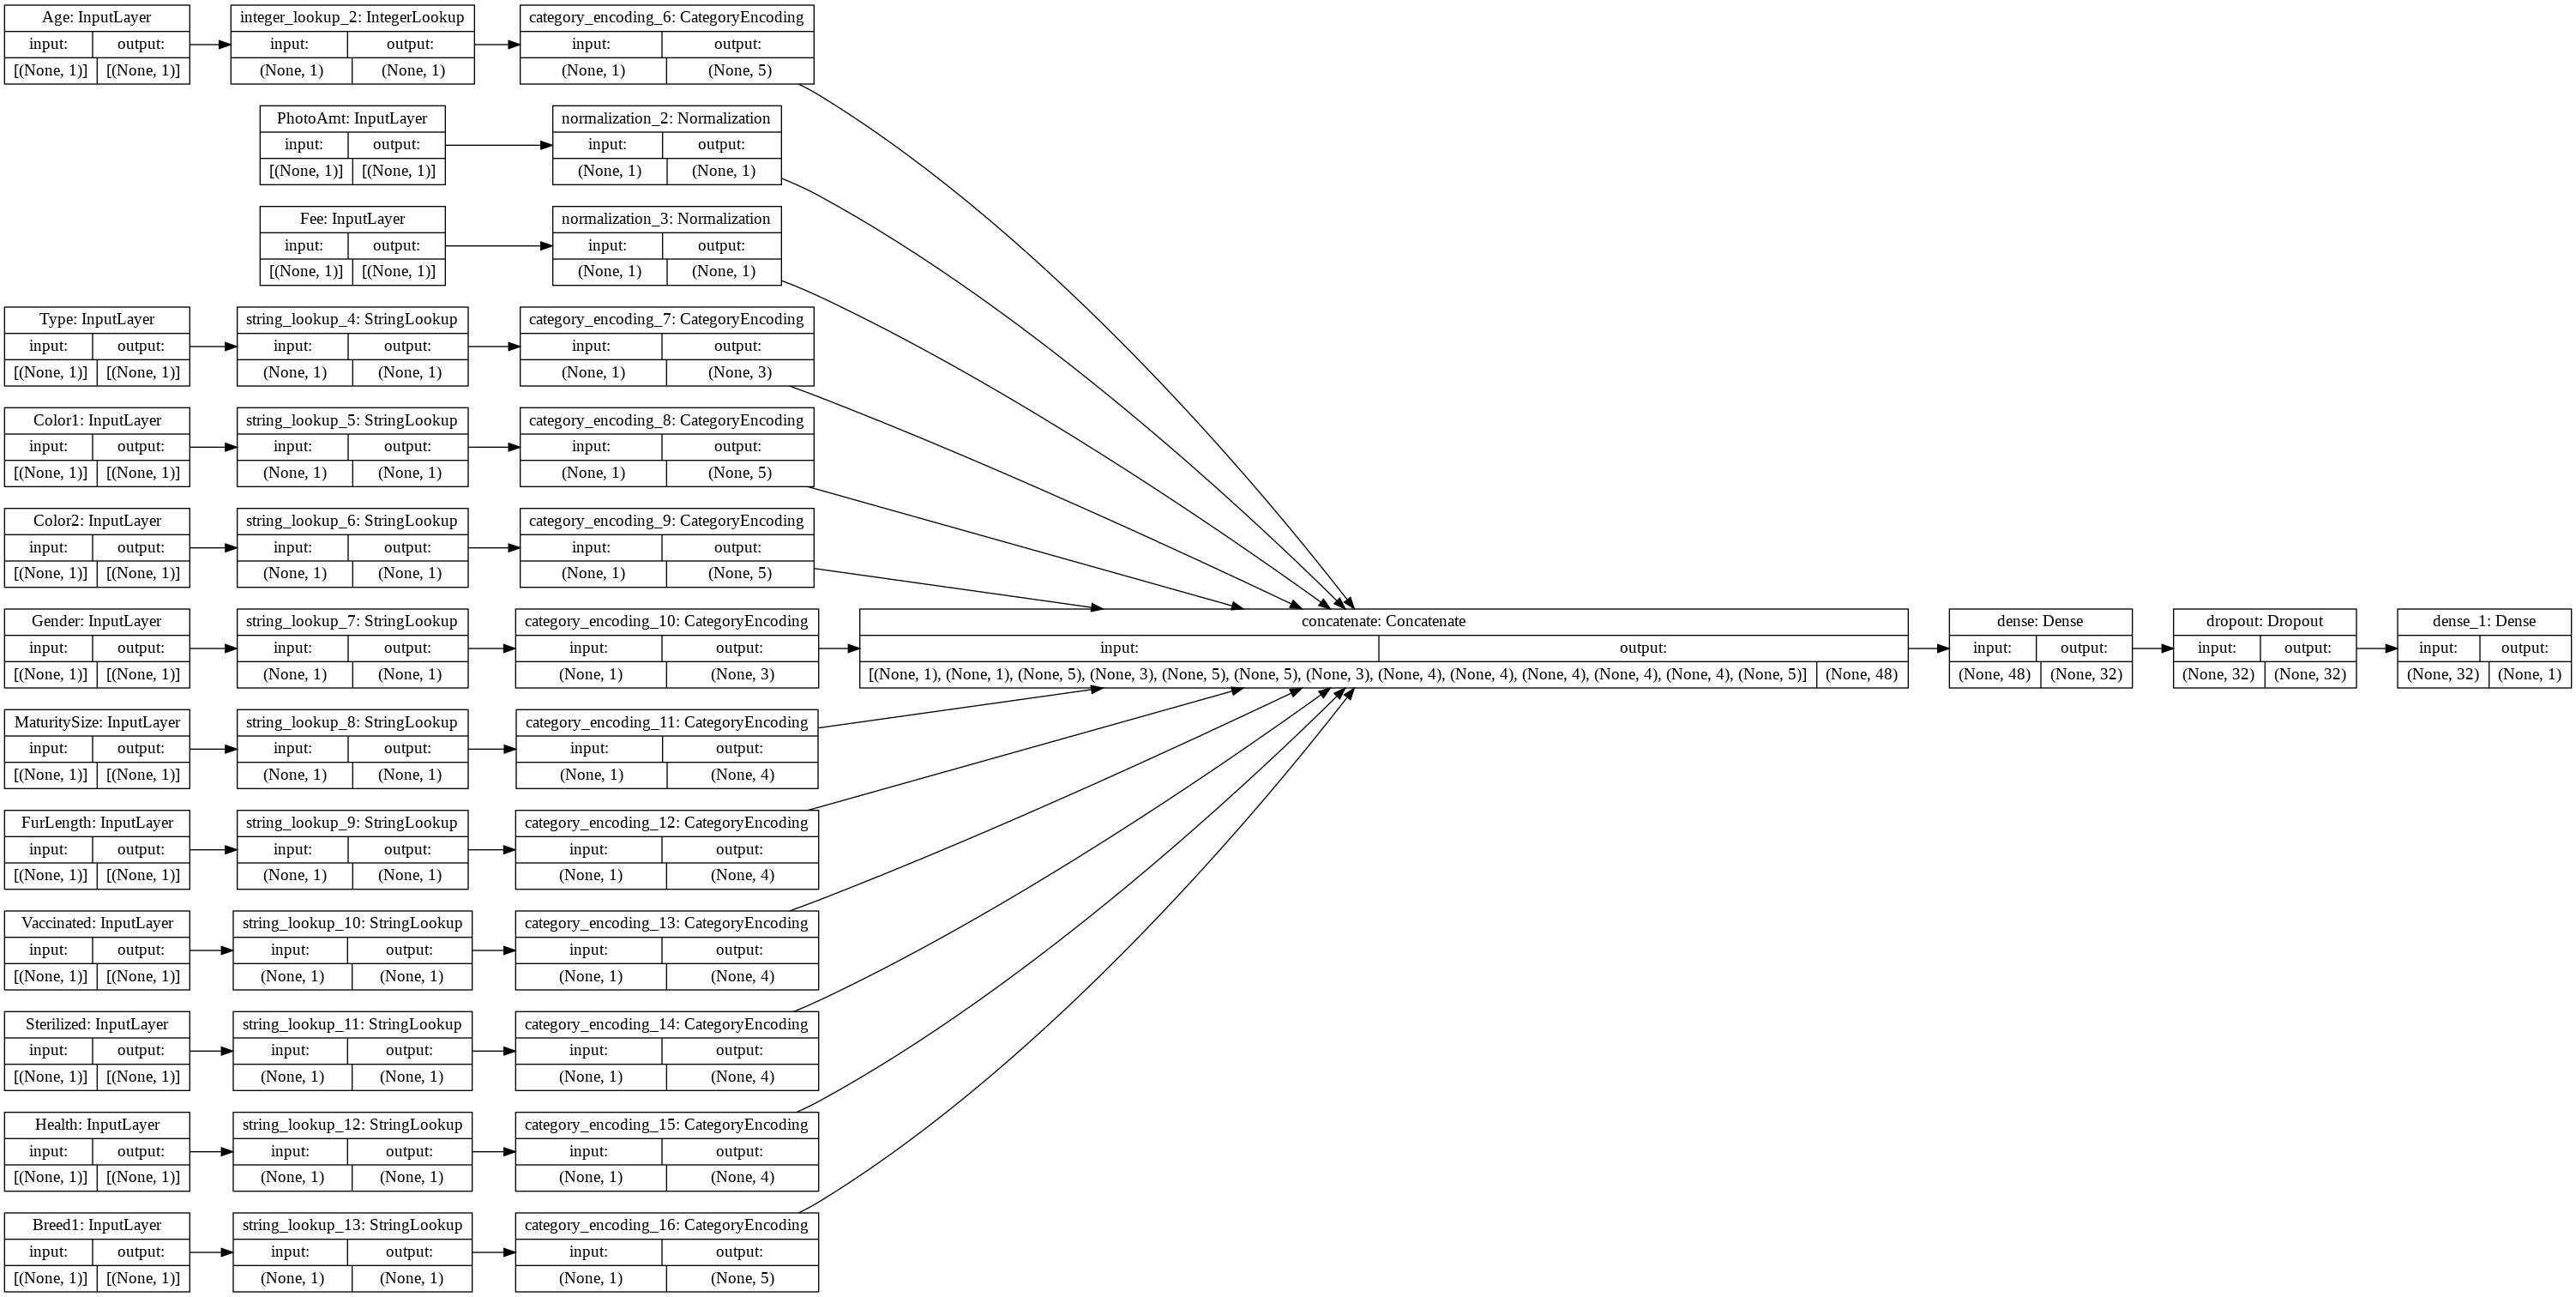

In [28]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


<a name='4-2'></a>
### 4.2 - Train & evaluate the model

In [38]:
history = model.fit(train_ds, epochs=40, validation_data=val_ds)

Epoch 1/40
29/29 [==============================] - 0s 6ms/step - loss: 0.4993 - accuracy: 0.7455 - val_loss: 0.4951 - val_accuracy: 0.7367
Epoch 2/40
29/29 [==============================] - 0s 8ms/step - loss: 0.5006 - accuracy: 0.7481 - val_loss: 0.4941 - val_accuracy: 0.7400
Epoch 3/40
29/29 [==============================] - 0s 6ms/step - loss: 0.5003 - accuracy: 0.7440 - val_loss: 0.4945 - val_accuracy: 0.7405
Epoch 4/40
29/29 [==============================] - 0s 8ms/step - loss: 0.4983 - accuracy: 0.7470 - val_loss: 0.4949 - val_accuracy: 0.7367
Epoch 5/40
29/29 [==============================] - 0s 8ms/step - loss: 0.5012 - accuracy: 0.7425 - val_loss: 0.4947 - val_accuracy: 0.7405
Epoch 6/40
29/29 [==============================] - 0s 7ms/step - loss: 0.5002 - accuracy: 0.7479 - val_loss: 0.4948 - val_accuracy: 0.7378
Epoch 7/40
29/29 [==============================] - 0s 6ms/step - loss: 0.5008 - accuracy: 0.7409 - val_loss: 0.4941 - val_accuracy: 0.7421
Epoch 8/40
29/29 [==

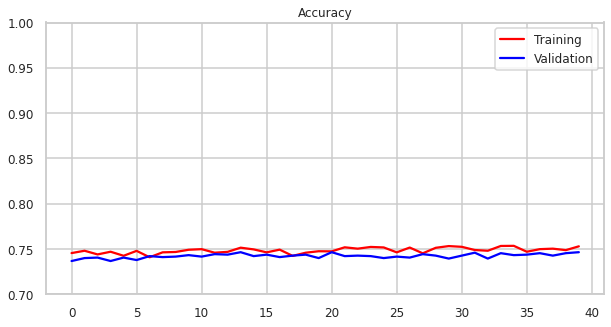

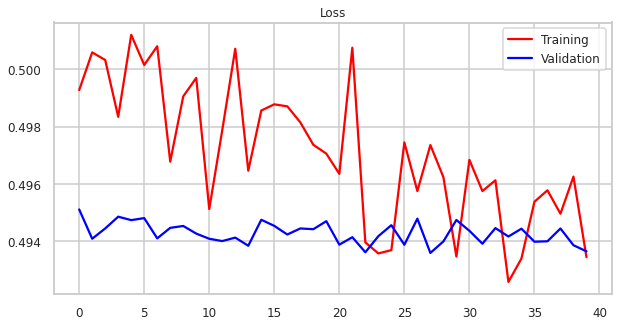

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.ylim(0.7, 1.0)
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Loss')
plt.legend()

plt.show()

In [32]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

10/10 [==============================] - 0s 3ms/step - loss: 0.4949 - accuracy: 0.7478
Accuracy 0.7478336095809937


<a name='5'></a>
## 5 - Inference on new data

**Key point**: The model we have developed can now classify a row from a CSV file directly because the preprocessing code is included inside the model itself.

We can now save and reload the Keras model


In [34]:
model_path = PROJECT_ROOT + '/' + 'my_pet_classifier'
model.save(model_path)
reloaded_model = tf.keras.models.load_model(model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GitHub/Keras-Structured-Data-Predicting-Adopted-Pets/my_pet_classifier/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GitHub/Keras-Structured-Data-Predicting-Adopted-Pets/my_pet_classifier/assets


To get a prediction for a new sample, we can simply call `model.predict()`. There are just two things we need to do:

1.   Wrap scalars into a list so as to have a batch dimension (models only process batches of data, not single samples)
2.   Call `convert_to_tensor` on each feature

In [36]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet has a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

This particular pet has a 71.4 percent probability of getting adopted.


## Key points:
*  We will typically see best results with deep learning with larger and more complex datasets. When working with a small dataset like this one, it is recommended using a decision tree or random forest as a strong baseline.

* To improve accuracy, think carefully about which features to include in the model, and how they should be represented.